In [38]:
import pandas as pd
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
image_folder = os.path.join(parent_dir, "Cuneiform Tests", "imgset")

# list of all images in the image folder and isolate char from iamge name
images = os.listdir(image_folder)
# remove any non-image files
images = [i for i in images if i.endswith(".png")]
char = [""] * len(images)
for i in range(len(images)):
    char[i] = images[i].split(".")[0].split("_")[1]

In [39]:
# create a dataframe with two columns: imagename and char
df = pd.DataFrame({'image': images, 'character': char})

# save the dataframe to a csv file
df.to_csv('imgset.csv', index=False)

In [40]:
df.head()

,image,character
0,15598_ni.png,ni
1,7530_zi.png,zi
2,9765_kusz.png,kusz
3,9088_1(disz).png,1(disz)
4,8178_1(asz@c).png,1(asz@c)


In [41]:
# drop characters with less than 10 images
df = df.groupby('character').filter(lambda x: len(x) >= 10)

classes = len(df['character'].unique())
print("Number of classes: ", classes, "in ", len(df), " images. Ratio: ", len(df)/classes, " images per class.")

Number of classes:  325 in  21729  images. Ratio:  66.85846153846154  images per class.


In [42]:
# use a label encoder to convert the characters to integers
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['label'] = le.fit_transform(df['character'])

df.head()

,image,character,label
0,15598_ni.png,ni,218
1,7530_zi.png,zi,320
3,9088_1(disz).png,1(disz),5
4,8178_1(asz@c).png,1(asz@c),1
5,17505_la.png,la,190


In [43]:
# use StratifiedShuffleSplit to split the data into training and testing sets

from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in sss.split(df['image'], df['character']):
    train = df.iloc[train_index]
    test = df.iloc[test_index]

# create a folder for the training and testing images
os.makedirs('imgset/Training_Data', exist_ok=True)
os.makedirs('imgset/Testing_Data', exist_ok=True)

# create df for training and testing images
train.to_csv('imgset/Training_Data/train.csv', index=False)
print("Training data: ", len(train))
test.to_csv('imgset/Testing_Data/test.csv', index=False)
print("Testing data: ", len(test))


Training data:  17383
Testing data:  4346


In [44]:
# get pixel width and height of images
from PIL import Image

img = Image.open(os.path.join(image_folder, images[0]))
width, height = img.size
print("Image size: ", width, "x", height)

Image size:  250 x 250


In [45]:
# create CNN model using Keras
# each image is 250x250 pixels and grayscale

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.calibration import LabelEncoder

# Create the CNN model
model = Sequential()

# Add convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(250, 250, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the feature maps
model.add(Flatten())

# Add fully connected layers
# model.add(Dense(256, activation='relu'))


model.add(Dense(3500, activation='relu'))
model.add(Dense(325, activation='softmax'))

/Users/Uni/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [46]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'recall', 'precision'])

# Print the model summary
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 248, 248, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 124, 124, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 122, 122, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 59, 59, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 29, 29, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 107648)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3500)           │   376,771,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 325)            │     1,137,825 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 378,001,997 (1.41 GB)

 Trainable params: 378,001,997 (1.41 GB)

 Non-trainable params: 0 (0.00 B)

In [47]:
# create a generator to load images in batches
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(
    dataframe=train,
    directory=image_folder,
    x_col='image',
    y_col='character',
    target_size=(250, 250),
    color_mode='grayscale',
    batch_size=10,
    class_mode='categorical')

# each argument explained:
# dataframe: the dataframe containing the image names and labels
# directory: the directory where the images are stored
# x_col: the column in the dataframe containing the image names
# y_col: the column in the dataframe containing the labels
# target_size: the size to which the images are resized
# color_mode: the color mode of the images
# batch_size: the batch size --> the number of images loaded in each batch, keep it low if you have a small memory
# class_mode: the type of labels --> 'categorical' for one-hot encoded labels

test_generator = datagen.flow_from_dataframe(
    dataframe=test,
    directory=image_folder,
    x_col='image',
    y_col='character',
    target_size=(250, 250),
    color_mode='grayscale',
    batch_size=10,
    class_mode='categorical')

Found 17383 validated image filenames belonging to 325 classes.
Found 4346 validated image filenames belonging to 325 classes.


In [48]:
# Layer Overview:
# Conv2D: 32 filters, 3x3 kernel, relu activation, input shape 50x50x1
    # used for feature extraction, which means that it extracts the most important features from the input image

# MaxPooling2D: 2x2 pool size
    # for each 2x2 pixel region, the maximum pixel value is taken: used to reduce the spatial dimensions of the output volume

# Flatten: flatten the feature maps
    # used to convert the 3D feature maps to 1D feature vectors: used to connect the convolutional layers to the dense layers

# Dense: 2 neurons, relu activation
    # used for classification: used to connect the flattened feature vectors to the output layer

# Dense: 325 neurons, softmax activation
    # used for classification: used to output the class probabilities


In [49]:
# train the model, save after each epoch
from keras.callbacks import ModelCheckpoint
import datetime

timestamp = datetime.datetime.now().strftime("%d.%m.%Y")

checkpoint = ModelCheckpoint("model_outputs/callbacks/" + timestamp + ".keras", save_best_only=True)
history = model.fit(train_generator, validation_data=test_generator, epochs=10, callbacks=[checkpoint])

# save model history as csv
history_df = pd.DataFrame(history.history)
history_df.to_csv('history_' + timestamp + '.csv', index=False)

Epoch 1/10


/Users/Uni/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1739/1739 ━━━━━━━━━━━━━━━━━━━━ 28512s 16s/step - accuracy: 0.1743 - loss: 4.5201 - precision: 0.6556 - recall: 0.0460 - val_accuracy: 0.4100 - val_loss: 2.7138 - val_precision: 0.7535 - val_recall: 0.2082
Epoch 2/10
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 9796s 6s/step - accuracy: 0.5418 - loss: 1.8624 - precision: 0.7827 - recall: 0.3768 - val_accuracy: 0.4961 - val_loss: 2.2815 - val_precision: 0.7218 - val_recall: 0.3665
Epoch 3/10
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 9494s 5s/step - accuracy: 0.8454 - loss: 0.5433 - precision: 0.9068 - recall: 0.7983 - val_accuracy: 0.4745 - val_loss: 2.8055 - val_precision: 0.5966 - val_recall: 0.4179
Epoch 4/10
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 10085s 6s/step - accuracy: 0.9676 - loss: 0.1096 - precision: 0.9730 - recall: 0.9622 - val_accuracy: 0.4356 - val_loss: 3.6968 - val_precision: 0.5199 - val_recall: 0.4004
Epoch 5/10
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 15595s 9s/step - accuracy: 0.9769 - loss: 0.0758 - precision: 0.9798 - recall: 0.9744 - val_accuracy: 0.4708 -

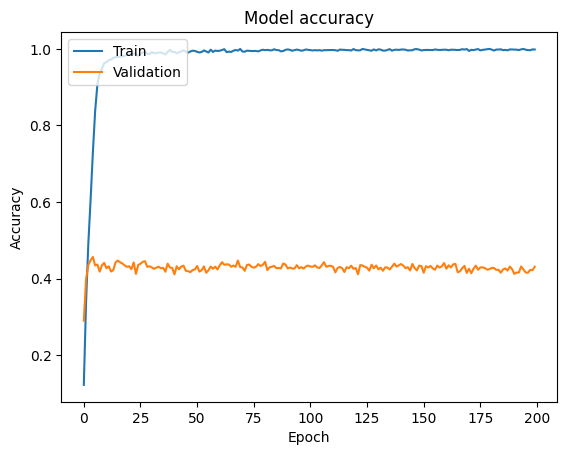

In [54]:
# create dataframe from csv, using first row as header
history_df = pd.read_csv('model_outputs/cuneiform_model_history.csv')

# plot the training and validation accuracy
import matplotlib.pyplot as plt

plt.plot(history_df['accuracy'])
plt.plot(history_df['val_accuracy'])
# add title and labels
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# save the plot in folder model_outputs
plt.savefig('model_outputs/cuneiform_model_history.png')


In [55]:
# test the model
#model.evaluate(test_generator)
model.evaluate(train_generator)

# save the model
#model.save('model_outputs/cuneiform_model' + date_time + '.keras')

1739/1739 ━━━━━━━━━━━━━━━━━━━━ 517s 297ms/step - accuracy: 0.9947 - loss: 0.0161 - precision: 0.9951 - recall: 0.9943


[0.016251668334007263,
 0.9949375987052917,
 0.9945924282073975,
 0.9954513907432556]

In [57]:
# test model with image from folder imgset

import numpy as np
# predict the character for the first 100 images in folder

correct_chars = []

# randomly pick 500 images
import random
random.seed(0)
random.shuffle(images)

pick = 500
for i in range(pick):
    img = Image.open(os.path.join(image_folder, images[i]))
    img = img.resize((250, 250))
    img = img.convert('L') # to grayscale
    img = np.array(img)
    img = img.reshape(1, 250, 250, 1)
    prediction = model.predict(img)
    real_char = images[i].split(".")[0].split("_")[1]
    print('\nreal character: ', real_char, '\n' ,'prediction: ' ,le.inverse_transform(np.argmax(prediction, axis=1))[0], '\n')
    if real_char == le.inverse_transform(np.argmax(prediction, axis=1))[0]:
        correct_chars.append(images[i])


print("Accuracy: ", len(correct_chars)/500)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step

real character:  a 
 prediction:  a 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step

real character:  in 
 prediction:  a 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step

real character:  lu2 
 prediction:  lu2 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step

real character:  1(disz) 
 prediction:  ma 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step

real character:  kux(KWU636) 
 prediction:  nin 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step

real character:  nun 
 prediction:  sila3 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step

real character:  a 
 prediction:  a 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step

real character:  an 
 prediction:  d 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step

real character:  lu2 
 prediction:  lugal 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step

real character:  na 
 prediction:  d 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step

real character:  iti 
 prediction:  ki 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step

real character:  mu 
 prediction:  na 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93

In [58]:
print(len(correct_chars), "out of ", pick)
print(correct_chars)

74 out of  500
['20890_a.png', '2550_lu2.png', '5530_a.png', '3521_u4.png', '9139_na.png', '19485_lugal.png', '23193_la2.png', '11495_1(disz).png', '15668_1(disz).png', '22972_dumu.png', '1163_d.png', '3275_a.png', '15041_lugal.png', '19962_iti.png', '14699_ki.png', '9582_d.png', '7891_d.png', '20328_ma.png', '22430_d.png', '4205_na.png', '14261_lu2.png', '568_d.png', '23095_mu.png', '19884_ki.png', '1581_ku.png', '10762_1(u).png', '18138_ba.png', '15094_lugal.png', '18174_ki.png', '16215_lu2.png', '20964_i.png', '2613_igi.png', '15497_ki.png', '20104_ba.png', '6565_8(disz).png', '5866_d.png', '19269_ma.png', '21483_d.png', '4341_lugal.png', '14203_de3.png', '7496_ur.png', '2413_ti.png', '4212_um.png', '13624_igi.png', '13169_ti.png', '7664_i3.png', '21516_ma.png', '1939_3(disz).png', '23179_da.png', '2453_a.png', '397_lugal.png', '632_a.png', '14501_sza.png', '4434_1(disz).png', '13917_ba.png', '10769_lu2.png', '1914_siki.png', '6288_iti.png', '12636_gesz.png', '3186_la.png', '8818_um